<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>



<CENTER>
</br>
<p><font size="5"> TAF MCE - 2020</span></p>
<p><font size="4">  UE Numerical Methods </font></p>
<p></p>
<p><font size="5">  Julia lab - constrained optimization </font></p>

**<p><font size="5">  Students NAME and FAMILY NAME: Alex SZAPIRO and Santiago QUINTEROS </font></p>**
</p></br>
</p>
</CENTER>

---------------------------

# <span style="color:#00B8DE">Constrained optimization</span>


Let us consider the following optimization problems

$$
(I) \left\{
\begin{array}{l}
\min_{x,y}x^4+y^4+(1-x)^2+2(1-y)^2\\
3x+y\ = 1
\end{array}
\right.
$$

and

$$
(II)\left\{
\begin{array}{l}
\min_{x,y}x^4+y^4+(1-x)^2+2(1-y)^2\\
(x+1)^2+(y-2)^2 \leq 1
\end{array}
\right.
$$

**1)** Plot the objective function and the constraints for both problems. 

**2)** Solve (I) with a Newton linearly constrained approach. How many steps of the algorithm are necessary for the constraint to be satisfied?

**3)** Solve (II) with an interior point approach.

**4)** **Optional -** Combine approaches used to solve (I) and (II) respectively to solve 

\begin{equation}
\displaystyle{
(III) {\left\{
\begin{array}{l}
\min_{x,y}x^4+y^4+(1-x)^2+2(1-y)^2\\
3x+y\ = 1\\
(x+1)^2+(y-2)^2 \leq 1
\end{array}
\right.}
}
\end{equation}


## <span style="color:#00B8DE">I - Objective and constraints plot

In [2]:
f(x::Vector) = x[1]^4 + x[2]^4 + (1-x[1])^2 + 2*(1-x[2])^2
h1(x::Vector) = 3*x[1] + x[2] - 1
h2(x::Vector) = (x[1]+1)^2 + (x[2]-2)^2 - 1

h2 (generic function with 1 method)

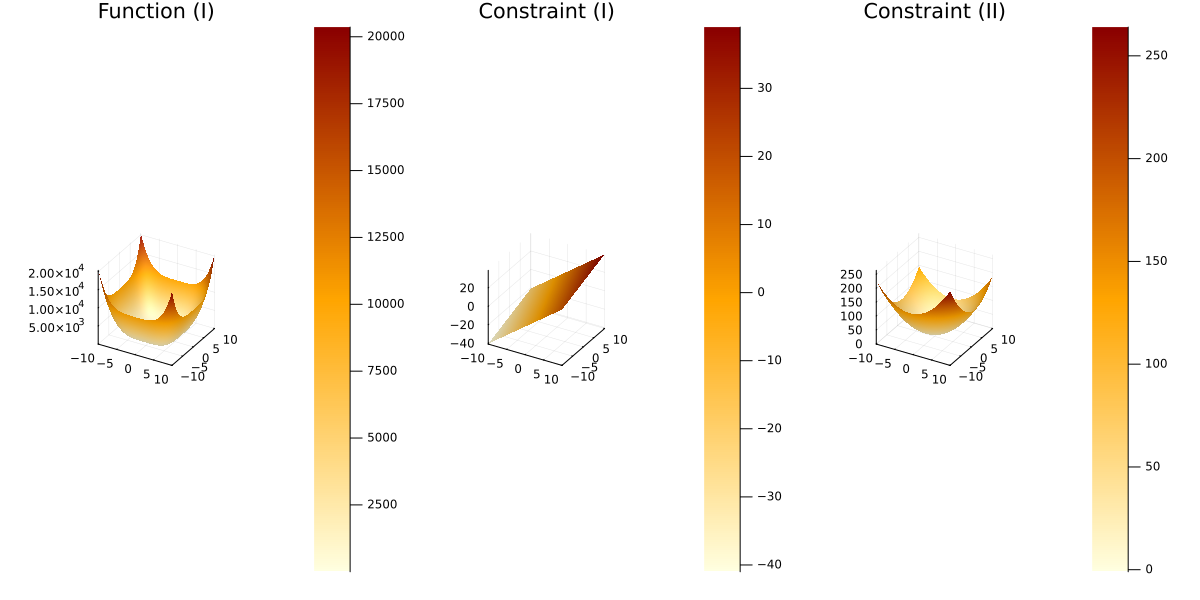

In [7]:
using Plots

default(size=(1200,600), fc=:heat)
x, y = -10:0.1:10, -10:0.1:10
zf = Surface((x,y)->f([x,y]), x, y)
zh1 = Surface((x,y)->h1([x,y]), x, y)
zh2 = Surface((x,y)->h2([x,y]), x, y)
plot(surface(x,y,zf, linealpha = 0.3), surface(x,y,zh1, linealpha = 0.3), surface(x,y,zh2, linealpha = 0.3), layout=(1,3), title=["Function (I)" "Constraint (I)" "Constraint (II)"])


## <span style="color:#00B8DE">II - Linearly constrained Newton

In [3]:
∇f(x::Vector) = [(4*x[1]^3 -2*(1-x[1])); (4*x[2]^3 -4*(1-x[2]))]
∇2f(x::Vector) = [12x[1]^2 + 2 0; 0 12x[2]^2 + 4]

h(x,y)  = 3*x[1] + x[2] - 1
∇h      = [3,1]

2-element Vector{Int64}:
 3
 1

In [4]:
# Backtracking
#-------------
function backtracking(x,f,∇f,d)
    """
    bactracking: 
    see e.g. https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf - p.464
    IN:
    ---
    x: initial point
    f, ∇f: function to be minimized and its gradient
    d: searc direction
    OUT:
    ----
    y: final point
    n: number of loops
    """
    α,β = 0.25, 0.7 # backtracking parameters
    p = 1 # multiplying factor
    n = 0
    while f(x+p*d) > f(x) + α*p*(transpose(d) * ∇f(x))
        p = β * p        
        n += 1
    end
    y = x + p*d
    return y,n
end

backtracking (generic function with 1 method)

In [5]:
prec        = 1.e-12
init        = [-1;2]

pt          = init
nb_iter_N   = 0  # number of loops
nb_loops_N  = 0  # number of inner loops count for backtracking
resu_N      = pt
A = [3 1] 
b = [1] # Ax = b for the constraint

while true
    
    mat1 = vcat(hcat(∇2f(pt), transpose(A)), [A 0])
    d_lambda = inv(mat1) * vcat(-∇f(pt), b - A*pt)

    d = d_lambda[1:2]
    lambda = d_lambda[3]

    pt, n_backtracking = backtracking(pt,f,∇f,d)

    nb_loops_N += n_backtracking
    nb_iter_N += 1

    resu_N = [resu_N pt]

    if (-∇f(pt)'*d) < prec  # ∇f(x+td)_{t=0}= ∇'*d
        break
    end    
end

In [6]:
println("Number of iterations for constrained Newton = $nb_iter_N")
println("Number of inner loops for constrained Newton = $nb_loops_N")

Number of iterations for constrained Newton = 6
Number of inner loops for constrained Newton = 0


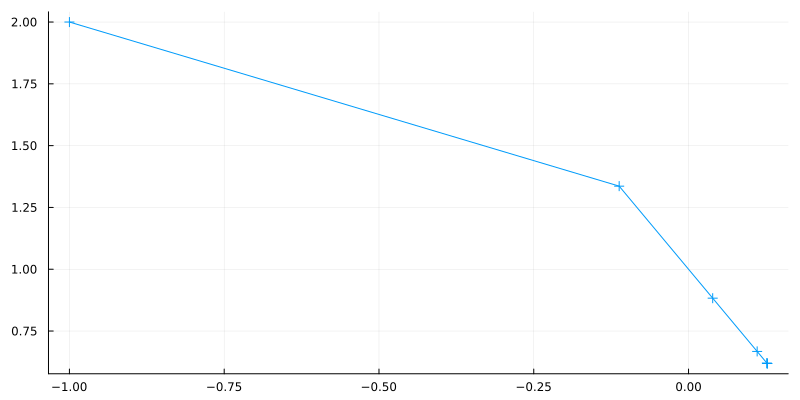

In [7]:
# Figure
plot(resu_N[1,:], resu_N[2,:], size=(800,400); marker=(:cross,5), legend=false)

resu_N[:, end] = [0.12714993224566, 0.6185502032630199]


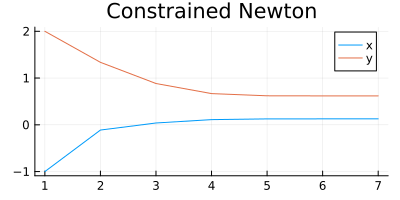

In [8]:
@show resu_N[:,end] # true solution: x = 0.1271, y = 0.6186

plot(resu_N[1,:],label="x")
plot!(resu_N[2,:],label="y",title="Constrained Newton",size=(400,200))

## <span style="color:#00B8DE">III - Interior point method

In [76]:
prec        = 1.e-8
init        = [-1,2]  # center of the circle
pt          = init
nb_iter_IP  = 0  # number of loops
nb_loops_IP = 0  # number of inner loops count for backtracking
resu_IP     = pt

mu = 10
α = 2
t = 1.5

g(x::Vector) = (x[1]+1)^2 + (x[2]-2)^2 - 1
∇g(x::Vector) = [2*(x[1]+1), 2*(x[2]-2)]
∇2g(x::Vector) = [2 0; 0 2]

phi(x::Vector) = -log(-g(x))
∇phi(x::Vector) = -∇g(x) ./ g(x)
∇2phi(x::Vector) = -∇2g(x) ./ g(x) + ∇phi(x) * ∇phi(x)'

while true
    for k=1:mu # inner loop
        # Solve with the Newton method for the new function
        d =  - inv(t*∇2f(pt)+∇2phi(pt)) * ((t*∇f(pt)+∇phi(pt)))

        pt, n_backtracking = backtracking(pt,f,∇f,d)
        nb_loops_IP += n_backtracking

    end

    t = α*t
    nb_iter_IP += 1 

    resu_IP = [resu_IP pt]
    if 1/t < prec  
        break
    end
end

In [77]:
println("Number of iterations for Interior point = $nb_iter_IP")
println("Number of inner loops for  Interior point = $nb_loops_IP")

Number of iterations for Interior point = 26
Number of inner loops for  Interior point = 17221


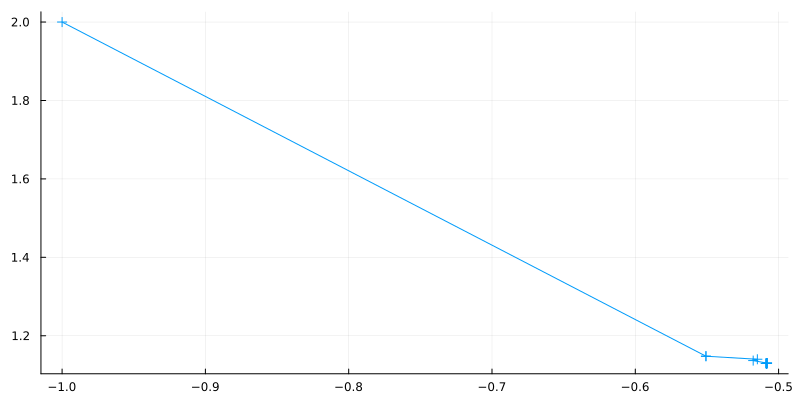

In [78]:
#Figure
plot(resu_IP[1,:], resu_IP[2,:], size=(800,400); marker=(:cross,5), legend=false)

resu_IP[:, end] = [-0.5084182532476321, 1.1291685673467595]


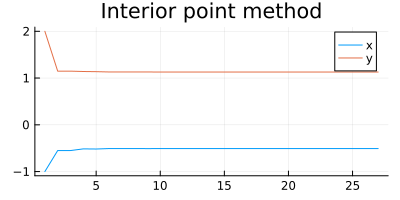

In [79]:
@show resu_IP[:,end] # true solution: x = -0.5084, y = 1.1292

plot(resu_IP[1,:],label="x")
plot!(resu_IP[2,:],label="y",title="Interior point method",size=(400,200))